# Centralized learning for ECG Arrhythmia detection


In [2]:
import lightning as L
import matplotlib.pyplot as plt
from lightning.pytorch.callbacks import TQDMProgressBar

from dataset_utils import Cinc2017DataModule
from model import DenseNetGruEcgModule

/home/g113056077/.pyenv/versions/awin-ecg/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Prepare the Dataset


In [3]:
dm = Cinc2017DataModule(batch_size=64)

## Create the Trainer


In [4]:
progress_bar_callback = TQDMProgressBar(leave=True)

trainer = L.Trainer(
    callbacks=[progress_bar_callback],
    logger=False,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


## Evaluate on the Test Set


In [5]:
import torch
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from torchmetrics.aggregation import CatMetric, MeanMetric
from torchmetrics.functional.classification import (
    multiclass_auroc,
    multiclass_average_precision,
)


def aggregate_metrics(results):
    loss_metric = MeanMetric()
    y_pred_metric = CatMetric()
    y_metric = CatMetric()

    for result in results:
        loss_metric.update(result["loss"])
        y_pred_metric.update(result["y_pred"])
        y_metric.update(result["y"])
    loss = loss_metric.compute()
    y_pred = y_pred_metric.compute()
    y = y_metric.compute().to(torch.long)
    y_hat = y_pred.argmax(dim=1).to(torch.long)

    return loss, y_pred, y, y_hat

### Best model

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 20/20 [00:01<00:00, 18.57it/s]
test_loss: 0.5684822201728821
test_auprc: 0.8639323115348816
test_auroc: 0.9315894246101379
              precision    recall  f1-score   support

           N       0.90      0.88      0.89       762
           A       0.80      0.86      0.83       114
           O       0.73      0.76      0.74       362

    accuracy                           0.84      1238
   macro avg       0.81      0.83      0.82      1238
weighted avg       0.84      0.84      0.84      1238



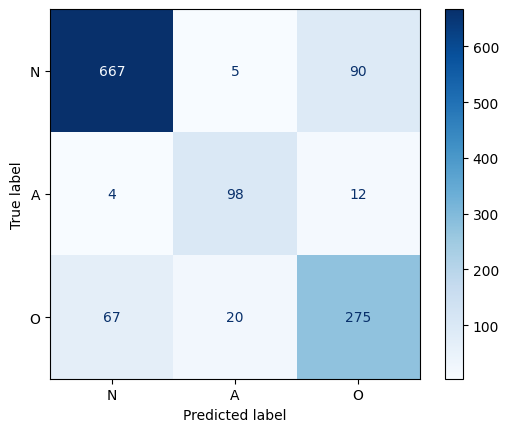

In [6]:
MODEL_PATH = "wandb_logs/awin-ecg-centralized/2ngbzxee/checkpoints/epoch=48-step=4459.ckpt"
model = DenseNetGruEcgModule.load_from_checkpoint(MODEL_PATH)
results = trainer.predict(model, dataloaders=dm)
test_loss, test_y_pred, test_y, test_y_hat = aggregate_metrics(results)

# loss
print(f"test_loss: {test_loss}")

# auprc
test_auprc = multiclass_average_precision(test_y_pred, test_y, num_classes=dm.num_classes)
print(f"test_auprc: {test_auprc}")

# auroc
test_auroc = multiclass_auroc(test_y_pred, test_y, num_classes=dm.num_classes)
print(f"test_auroc: {test_auroc}")

# classification report
print(classification_report(test_y, test_y_hat, target_names=dm.test_set.classes))

# confusion matrix
test_cm = confusion_matrix(test_y, test_y_hat)
test_cm_disp = ConfusionMatrixDisplay(
    confusion_matrix=test_cm, display_labels=dm.test_set.classes
)
test_cm_disp.plot(cmap="Blues")
plt.show()

## Debug

In [7]:
error_y = test_y.numpy() != test_y_hat.numpy()
true_lables = test_y[error_y].numpy()
pred_lables = test_y_hat[error_y].numpy()
error_idx = [i for i, e in enumerate(error_y) if e]
error_signals = [dm.test_set[i]['signal'][0] for i in range(len(dm.test_set)) if error_y[i]]
error_records_name = dm.test_set.dataset_df[error_y]["record_name"].tolist()

record name: A00066
True: N
Pred: O


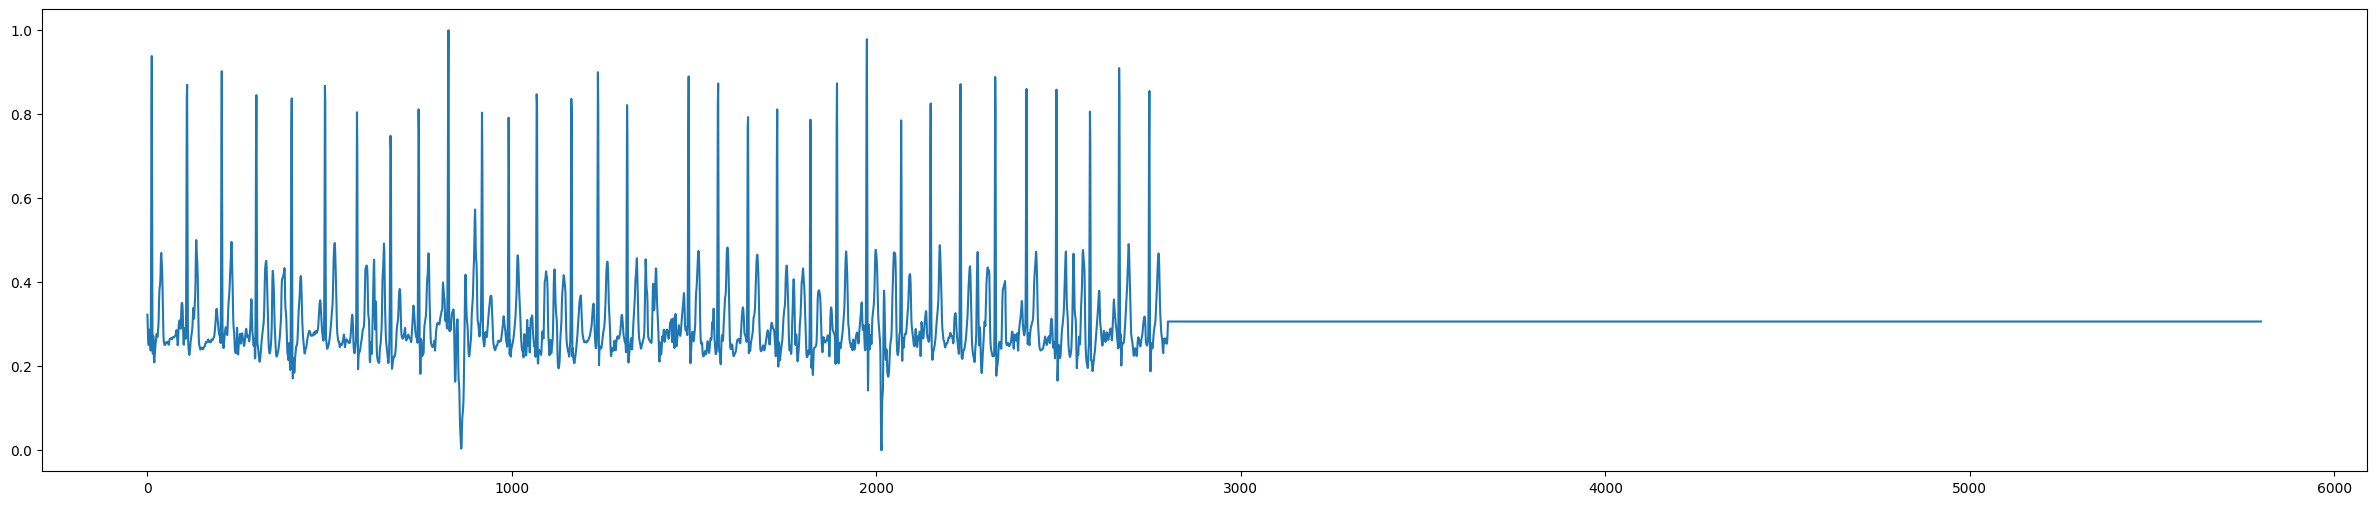

record name: A00093
True: N
Pred: O


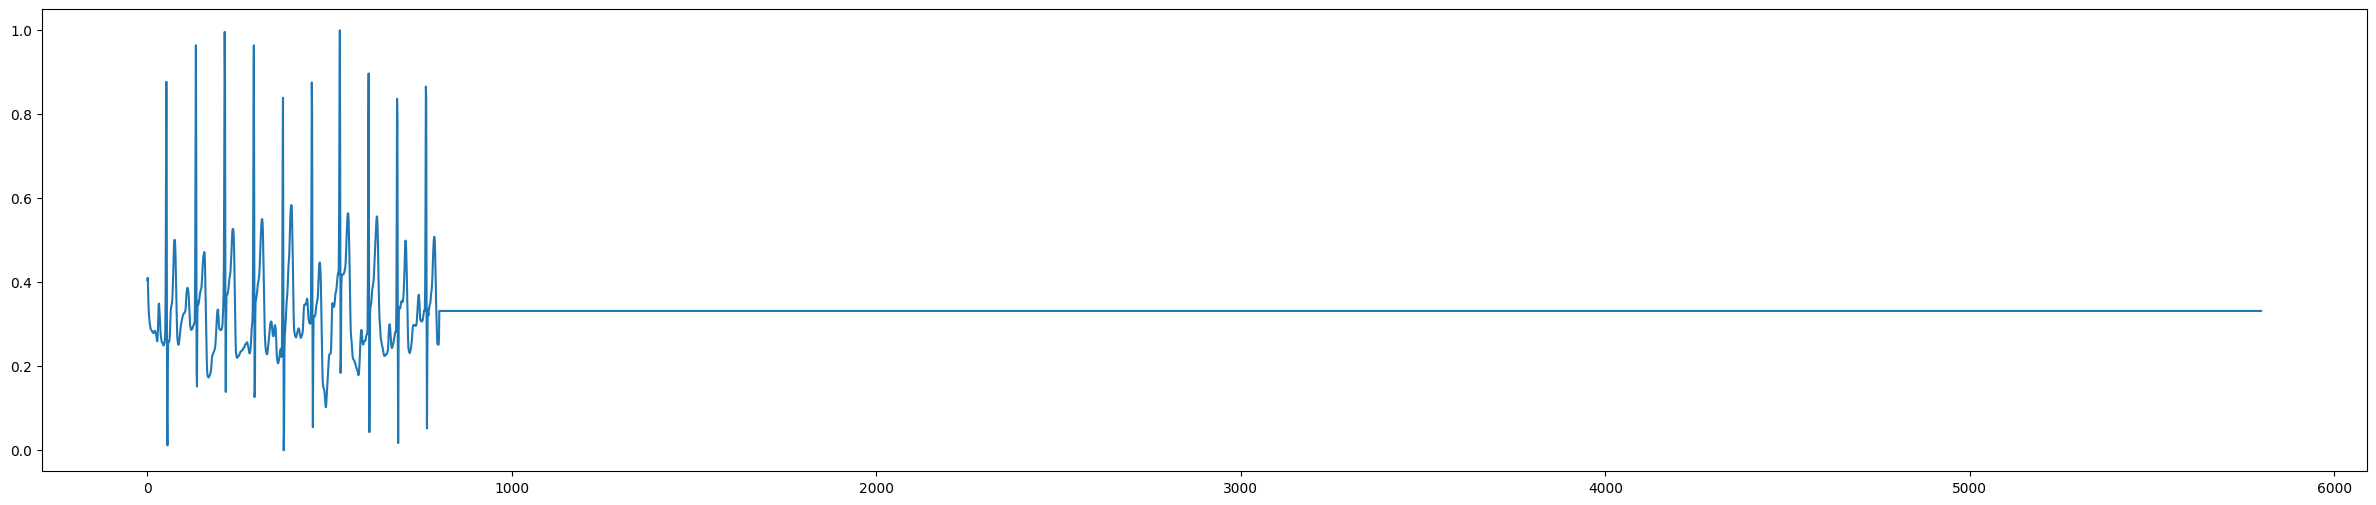

record name: A00100
True: O
Pred: A


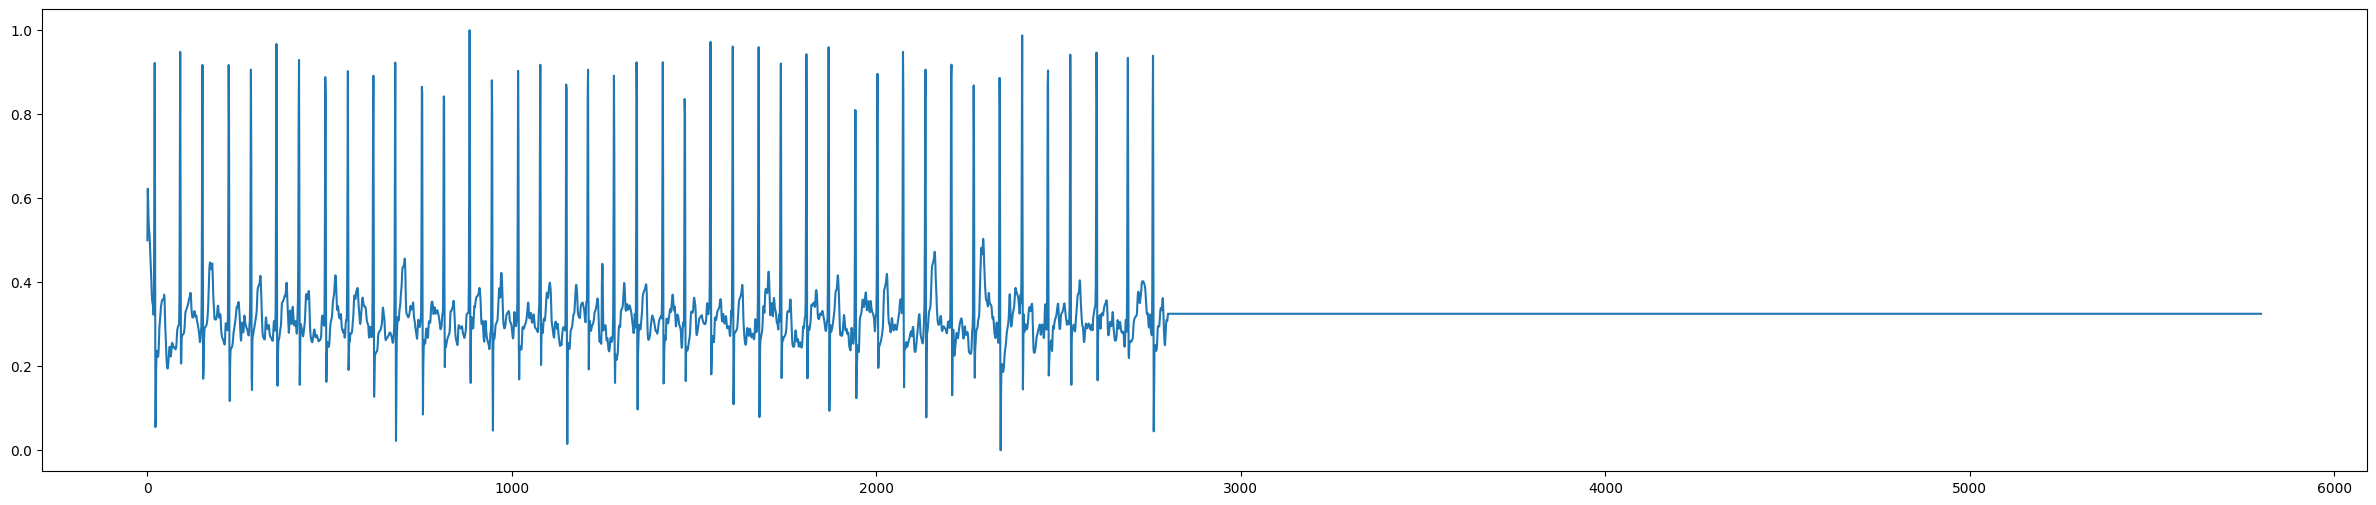

record name: A00380
True: N
Pred: O


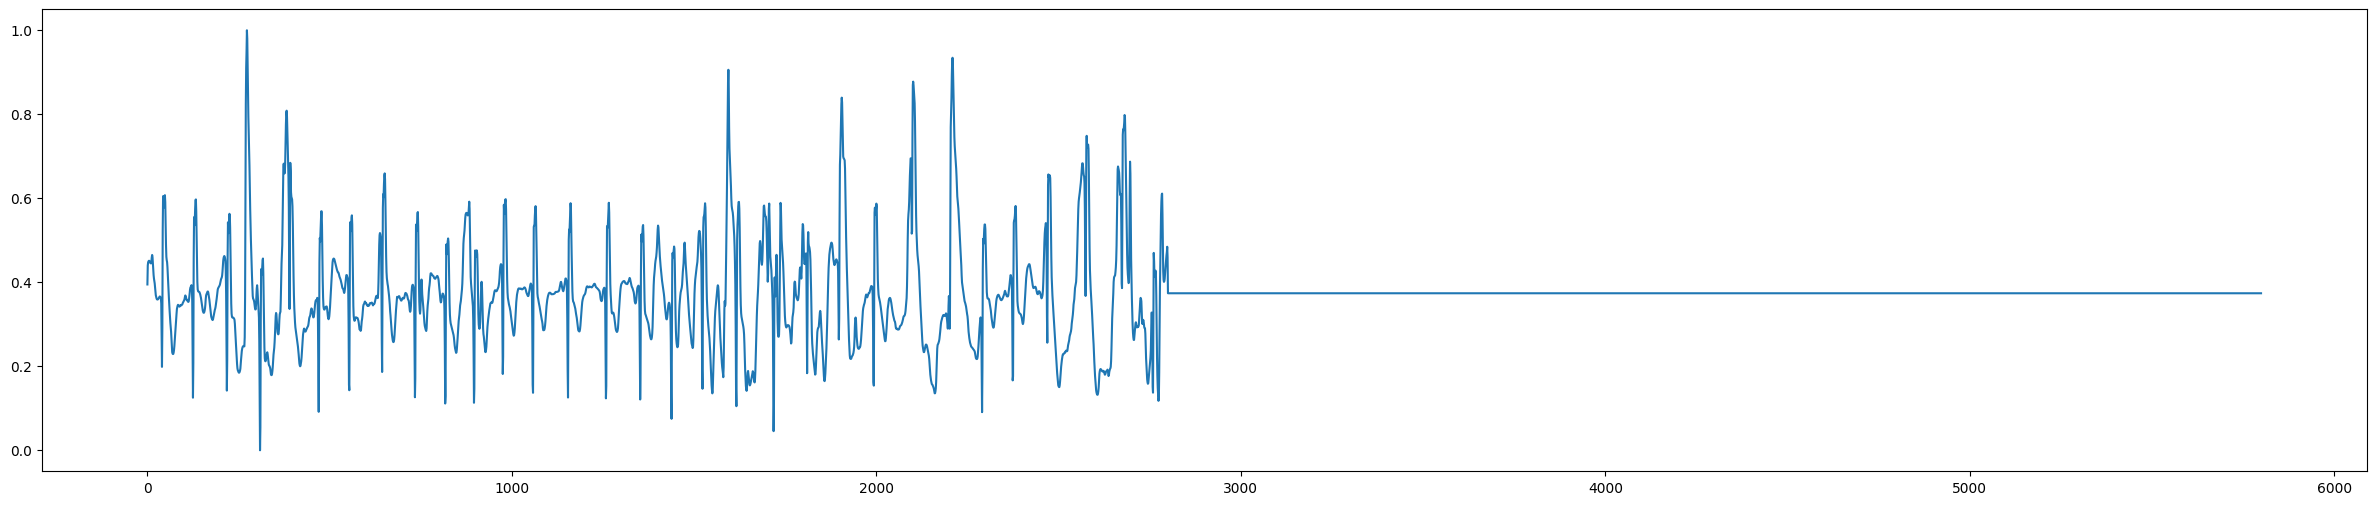

record name: A00402
True: O
Pred: N


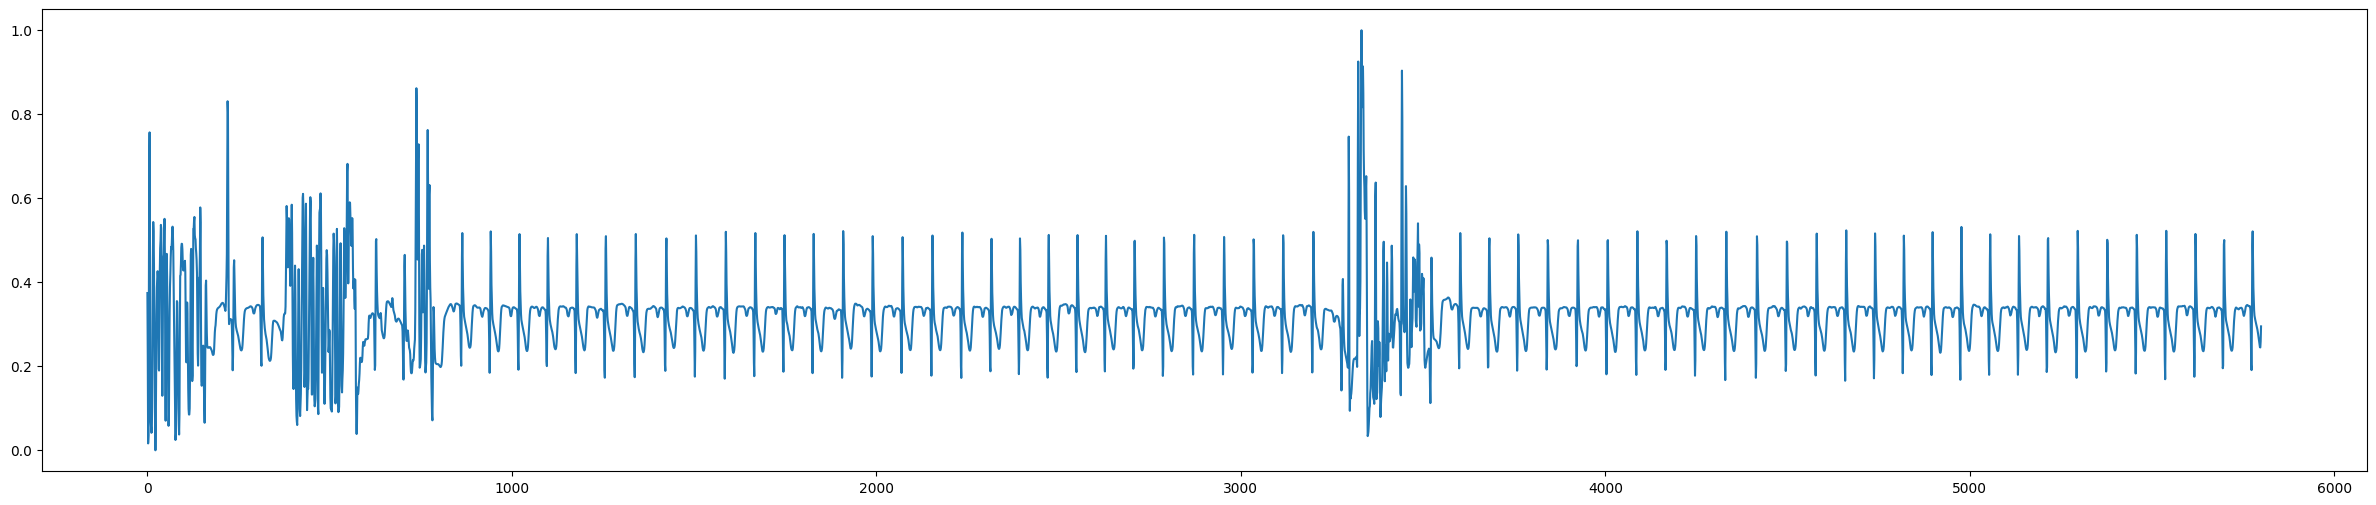

record name: A00404
True: A
Pred: O


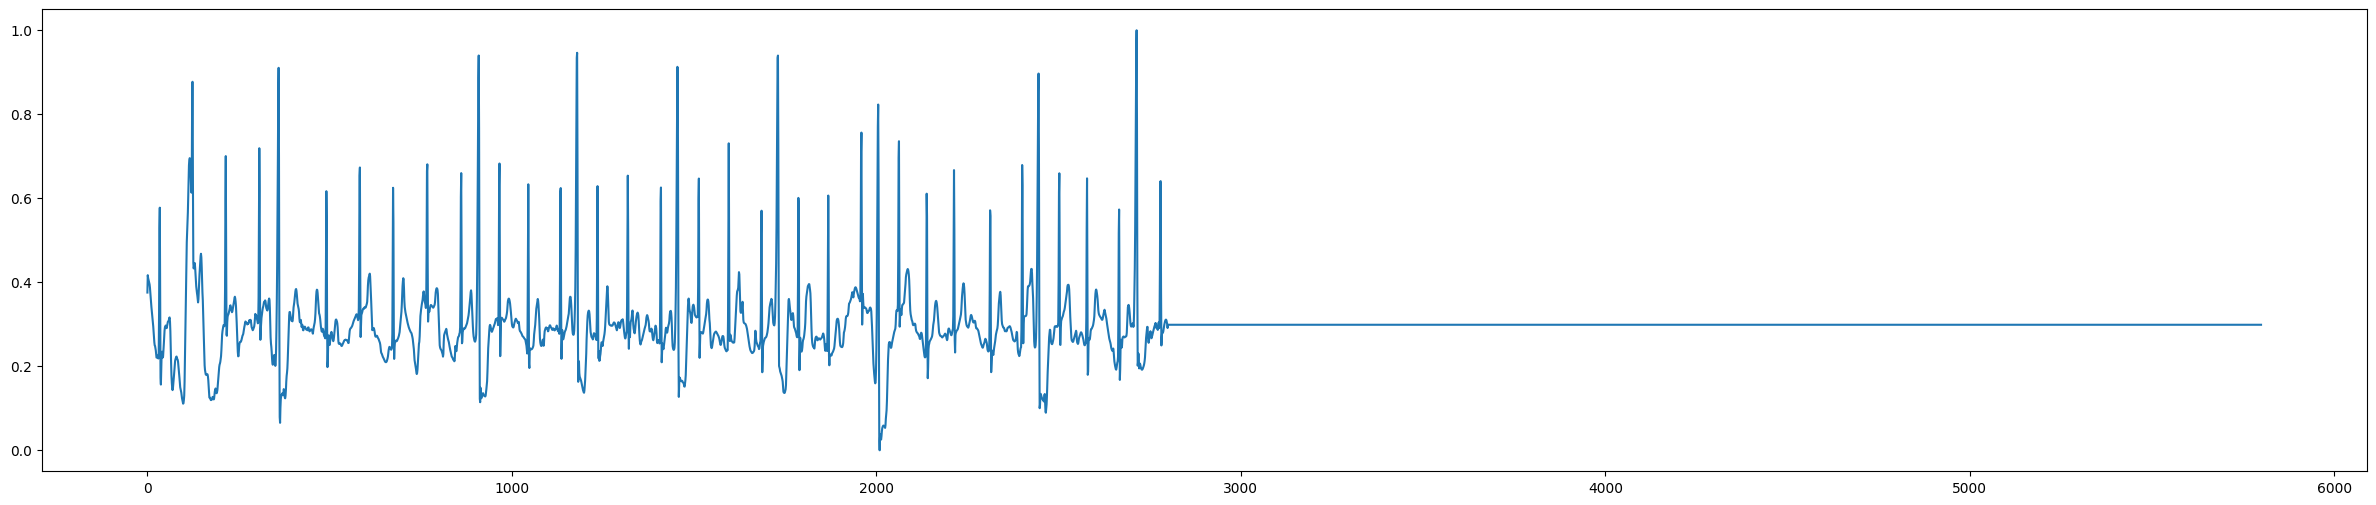

record name: A00502
True: O
Pred: A


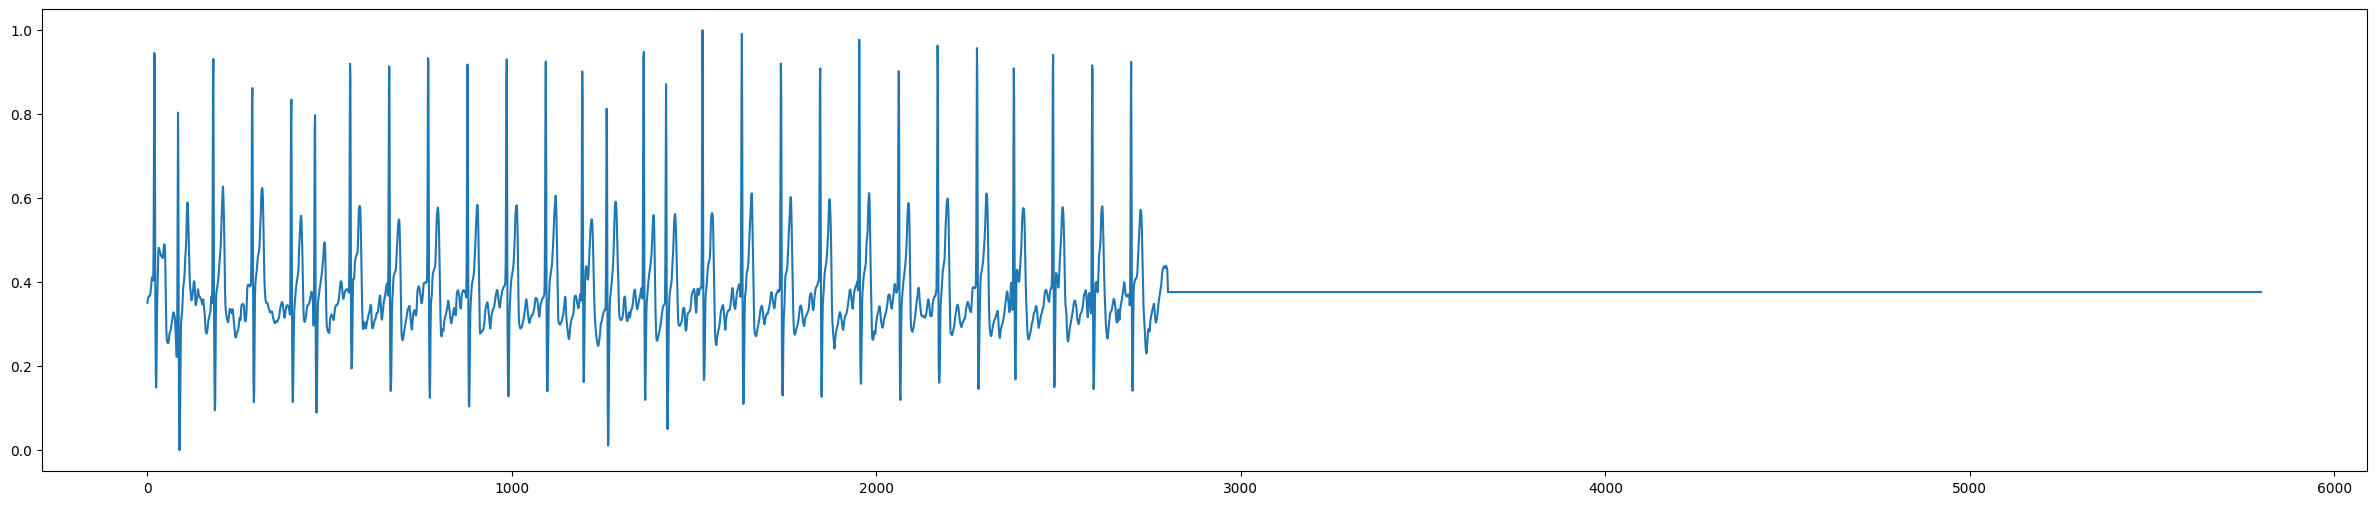

record name: A00535
True: O
Pred: N


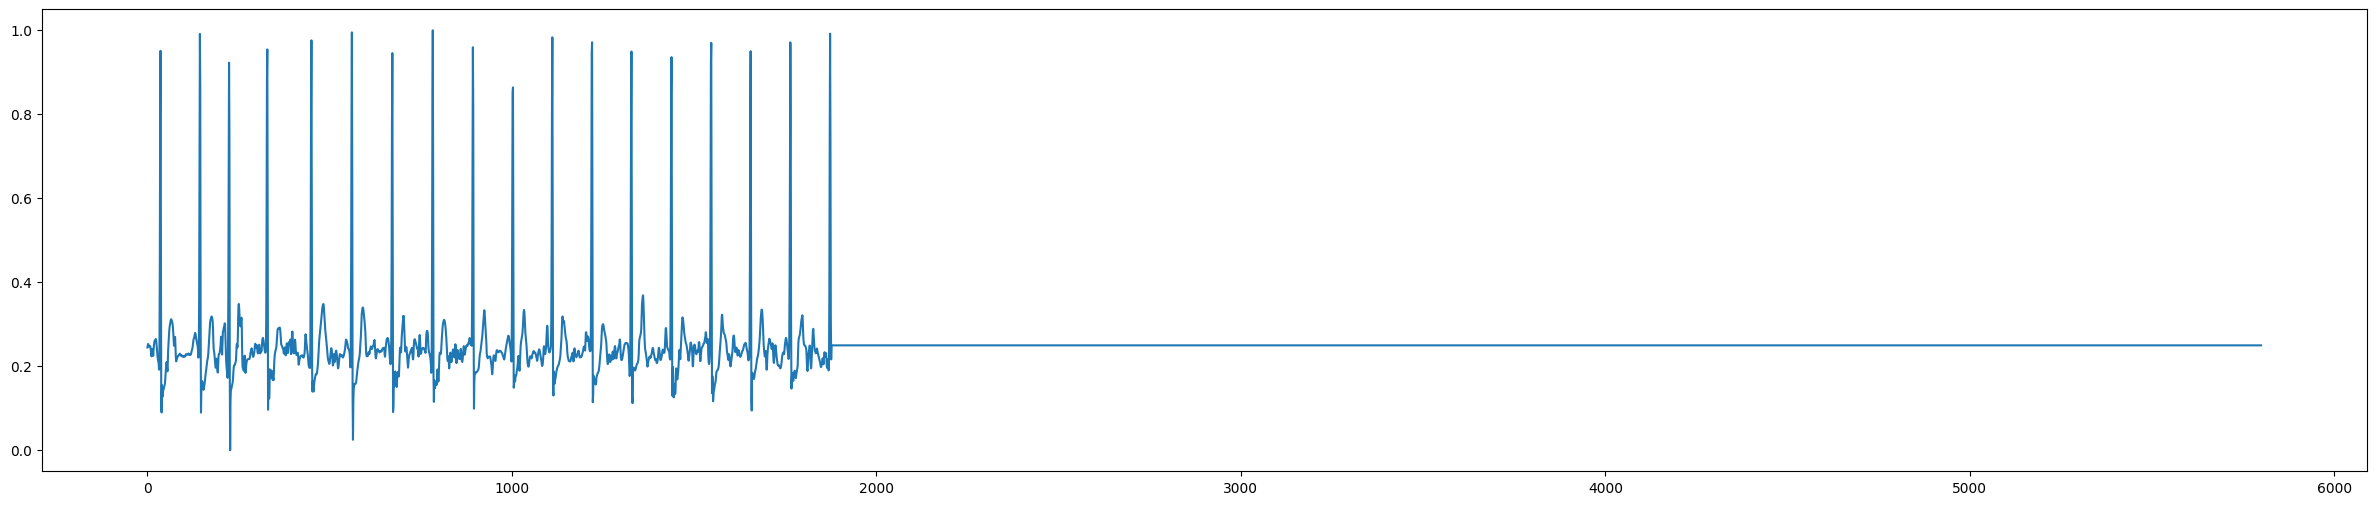

record name: A00536
True: O
Pred: N


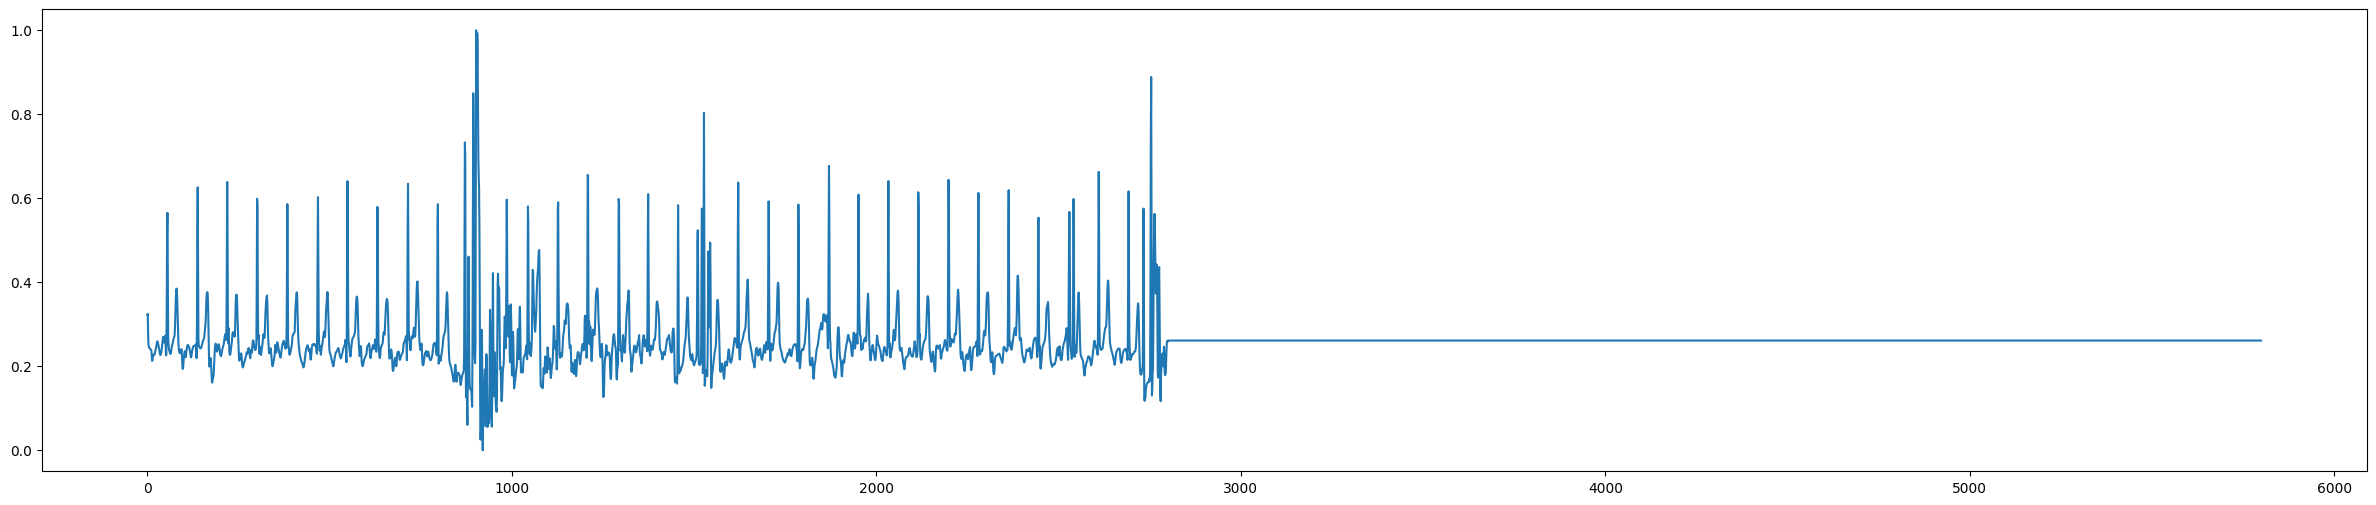

record name: A00802
True: N
Pred: O


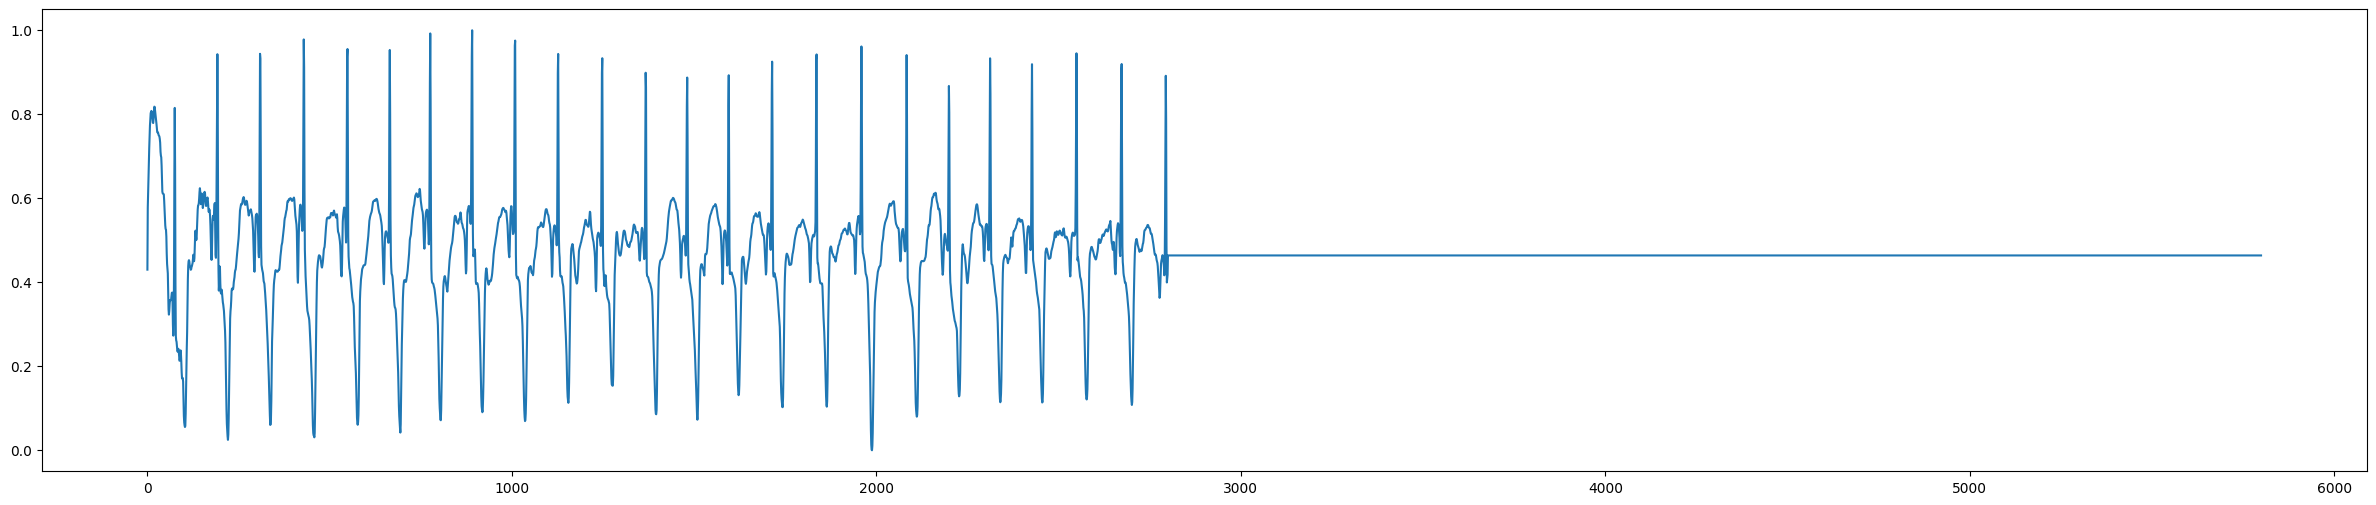

In [8]:
for idx in range(10):
    print(f"record name: {error_records_name[idx]}")
    print(f"True: {dm.test_set.label_decoder[true_lables[idx]]}")
    print(f"Pred: {dm.test_set.label_decoder[pred_lables[idx]]}")
    plt.figure(figsize=(30, 6))
    plt.plot(error_signals[idx])
    plt.show()